<a href="https://colab.research.google.com/github/ivanpalenciab/prediccion-precio-maiz/blob/master/XG_boost_EMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [3]:
modo_1 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_1.csv")
modo_2 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_2.csv")
modo_3 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_3.csv")
modo_4 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_4.csv")
modo_5 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_5.csv")
residuo = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/residuo.csv")
modos = [modo_1,modo_2,modo_3,modo_4,modo_5,residuo]

for i in modos:
  i["Fecha"] = pd.to_datetime(i["Fecha"],format='%Y-%m-%d')
  i.set_index("Fecha", inplace=True)


In [4]:
type(modo_1.index)

pandas.core.indexes.datetimes.DatetimeIndex

<Axes: xlabel='Fecha'>

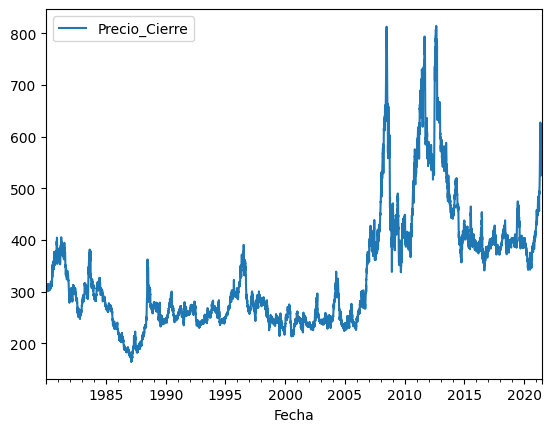

In [5]:
datos_emd = modo_1 + modo_2 + modo_3 + modo_4 + modo_5 + residuo
datos_emd = datos_emd.asfreq('D')
datos_emd.interpolate(inplace=True)
datos_emd.plot()

In [6]:
def add_lags(df,pasos):
    target_map = df['Precio_Cierre'].to_dict()
    for i in range(pasos+1):
      df[f'retraso-{i}'] = (df.index - pd.Timedelta(f'{i} days')).map(target_map)
    df = df.drop(columns=["retraso-0"])
    df.dropna(inplace=True)
    return df

In [7]:
PASOS = 7

In [8]:
CARACTERISTICAS = [ "retraso-1", "retraso-2",	"retraso-3",	"retraso-4",	"retraso-5",	"retraso-6",	"retraso-7"]

# Modelaremos el primer modo

In [9]:
modo_1 = modo_1.asfreq('D')
modo_1.interpolate(inplace=True)


In [10]:
modo_1_values = modo_1.values
modo_1_values = modo_1_values.astype('float32')
modo_1_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_1_values = modo_1_values.reshape(-1, 1)
modo_1_escalado =  pd.DataFrame(modo_1_scaler.fit_transform(modo_1_values), columns=modo_1.columns,index=modo_1.index)
modo_1_sup = add_lags(modo_1_escalado, PASOS)
modo_1_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,-0.016878,0.017245,0.051367,0.085490,0.119612,0.153734,0.026287,-0.111422
1980-01-10,-0.094281,-0.016878,0.017245,0.051367,0.085490,0.119612,0.153734,0.026287
1980-01-11,0.027963,-0.094281,-0.016878,0.017245,0.051367,0.085490,0.119612,0.153734
1980-01-12,0.013704,0.027963,-0.094281,-0.016878,0.017245,0.051367,0.085490,0.119612
1980-01-13,-0.000555,0.013704,0.027963,-0.094281,-0.016878,0.017245,0.051367,0.085490


In [11]:
total_datos=len(modo_1_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m1 = modo_1_sup[:division_entrenamiento]
datos_validacion_m1 = modo_1_sup[division_entrenamiento:division_validacion]
datos_testeo_m1 = modo_1_sup[division_validacion:total_datos]

In [12]:
total_datos=len(modo_1.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = modo_1[:division_entrenamiento]
datos_validacion = modo_1[division_entrenamiento:division_validacion]
datos_testeo = modo_1[division_validacion:total_datos]

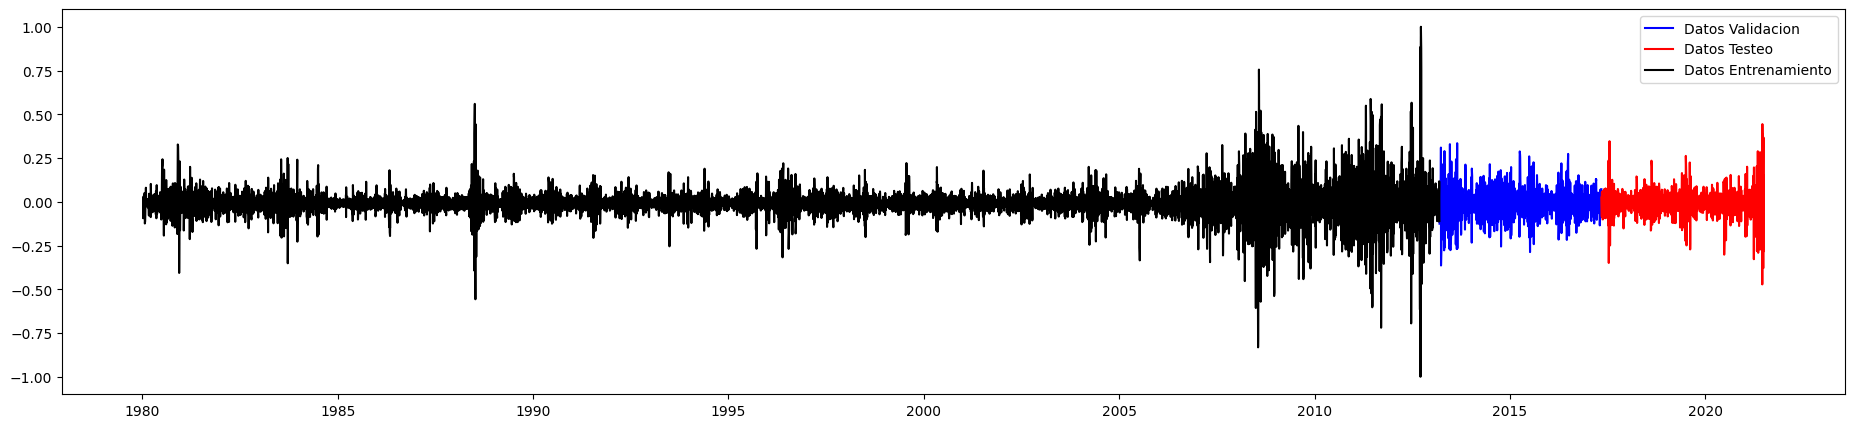

In [13]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_m1.index,datos_validacion_m1.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [14]:
learning_rate = [0.01, 0.1, 0.2]
max_depth = [2,3, 4, 5,6,7,8]
subsample = [0.8, 0.9, 1.0]
colsample_bytree = [0.7,0.8, 0.9, 1.0]

errores_learning_rate = []
errores_max_depth = {"i":{"j":[]}}
errores = []

X_train = datos_entrenamiento_m1[CARACTERISTICAS]
y_train =  datos_entrenamiento_m1.Precio_Cierre

X_test = datos_validacion_m1[CARACTERISTICAS]
y_test = datos_validacion_m1.Precio_Cierre

for i in learning_rate:
  for j in max_depth:
    for k in subsample:
      reg = xgb.XGBRegressor( base_score= None , booster= None ,
                            n_estimators= 1000 ,
                            early_stopping_rounds= 50 ,
                            subsample=k,
                            max_depth= j ,
                            learning_rate= i )


      reg.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=0)
      y_predict = reg.predict(datos_validacion_m1[CARACTERISTICAS])
      y_predict = pd.Series(y_predict)

      #score = mean_absolute_percentage_error(y_predict,datos_validacion_m2.Precio_Cierre)
      score = np.sqrt(mean_squared_error(y_predict,datos_validacion_m1.Precio_Cierre))

      errores.append((i,j,k,score))

In [15]:
indice, valor_minimo = min(enumerate(errores), key=lambda x: x[1][3])

print("El número más pequeño en la posición 3 de las tuplas es:", valor_minimo[3])
print("El índice de la tupla con el número más pequeño es:", indice)
print( f"el learning rate es {errores[indice][0]} el max_depth es {errores[indice][1]} y el subsample es {errores[indice][2]}")

El número más pequeño en la posición 3 de las tuplas es: 0.07554919
El índice de la tupla con el número más pequeño es: 18
el learning rate es 0.01 el max_depth es 8 y el subsample es 0.8


In [16]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
modo_1_sup = modo_1_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_1_sup[:division_validacion]) :
    train = modo_1_sup.iloc[train_idx]
    test = modo_1_sup.iloc[val_idx]

    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 8 ,
                           learning_rate= 0.01,
                            subsample= 0.8
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

    validacion_modo_1 = reg.predict(X_test)
    validacion_modo_1 = pd.Series(validacion_modo_1)
    preds.append(validacion_modo_1)
    score = np.sqrt(mean_squared_error(validacion_modo_1,y_test))
    mae = mean_absolute_error(validacion_modo_1,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_1,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_modo_1 = reg.predict(datos_validacion_m1[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

Puntuación entre pliegues 0.06613054871559143 
Puntuaciones plegar: [0.07115407, 0.06272813, 0.06450945] 
Error Absoluto medio entre pliegues 0.04772573336958885
porcentaje de error absoluto medio entre pliegues 23.519208908081055


In [17]:
OBJETIVO = 'Precio_Cierre'

X_train=modo_1_sup[CARACTERISTICAS][:division_validacion]
y_train = modo_1_sup[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)


prediccion_modo_1 = reg.predict(datos_testeo_m1[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo_m1[OBJETIVO],prediccion_modo_1))

print(f"El error Cuadratico medio del modelo es {score}")

El error Cuadratico medio del modelo es 0.0681299939751625


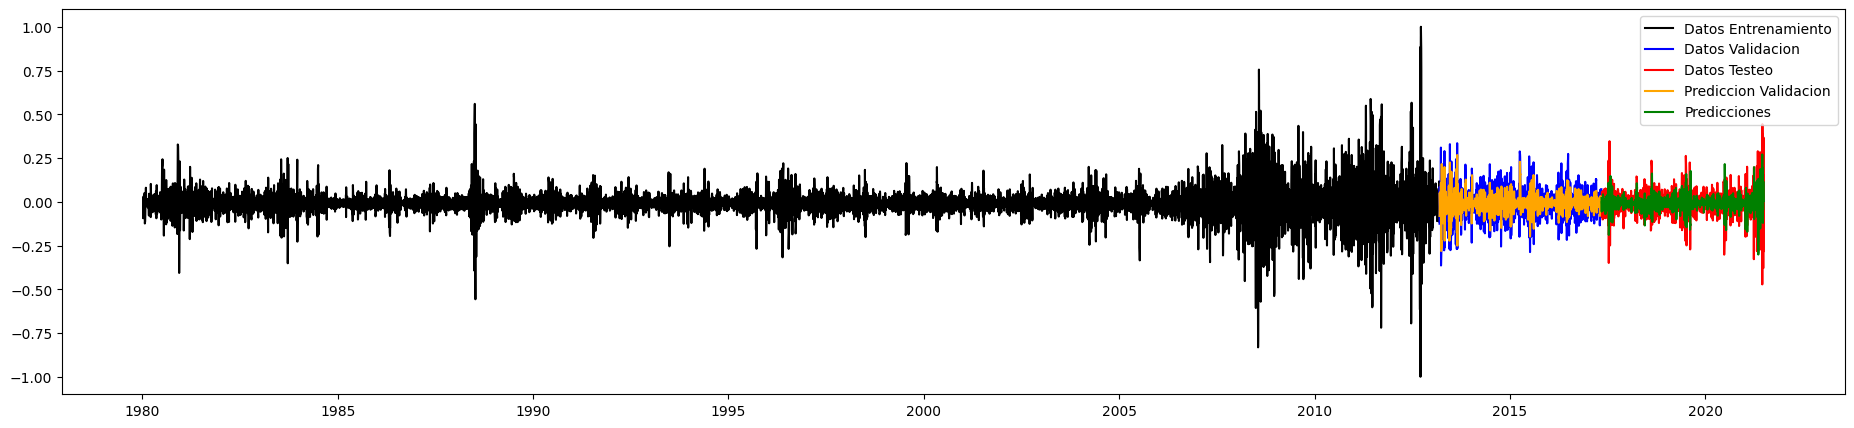

In [18]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m1.index,datos_validacion_m1.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_m1.index,validacion_modo_1,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_m1.index,prediccion_modo_1,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [19]:
validacion_modo_1 = modo_1_scaler.inverse_transform(validacion_modo_1.reshape(-1, 1))
prediccion_modo_1 = modo_1_scaler.inverse_transform(prediccion_modo_1.reshape(-1, 1))

# Modelaremos el segundo modo

In [20]:
modo_2 = modo_2.asfreq('D')
modo_2.interpolate(inplace=True)

In [21]:
modo_2_values = modo_2.values
modo_2_values = modo_2_values.astype('float32')
modo_2_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_2_values = modo_2_values.reshape(-1, 1)
modo_2_escalado =  pd.DataFrame(modo_2_scaler.fit_transform(modo_2_values), columns=modo_2.columns,index=modo_2.index)
modo_2_sup = add_lags(modo_2_escalado, PASOS)
modo_2_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,0.106661,0.118728,0.130794,0.142860,0.154927,0.166993,0.237516,0.307612
1980-01-10,0.081927,0.106661,0.118728,0.130794,0.142860,0.154927,0.166993,0.237516
1980-01-11,0.108178,0.081927,0.106661,0.118728,0.130794,0.142860,0.154927,0.166993
1980-01-12,0.120142,0.108178,0.081927,0.106661,0.118728,0.130794,0.142860,0.154927
1980-01-13,0.132105,0.120142,0.108178,0.081927,0.106661,0.118728,0.130794,0.142860


In [22]:
total_datos=len(modo_2_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m2 = modo_2_sup[:division_entrenamiento]
datos_validacion_m2 = modo_2_sup[division_entrenamiento:division_validacion]
datos_testeo_m2 = modo_2_sup[division_validacion:total_datos]

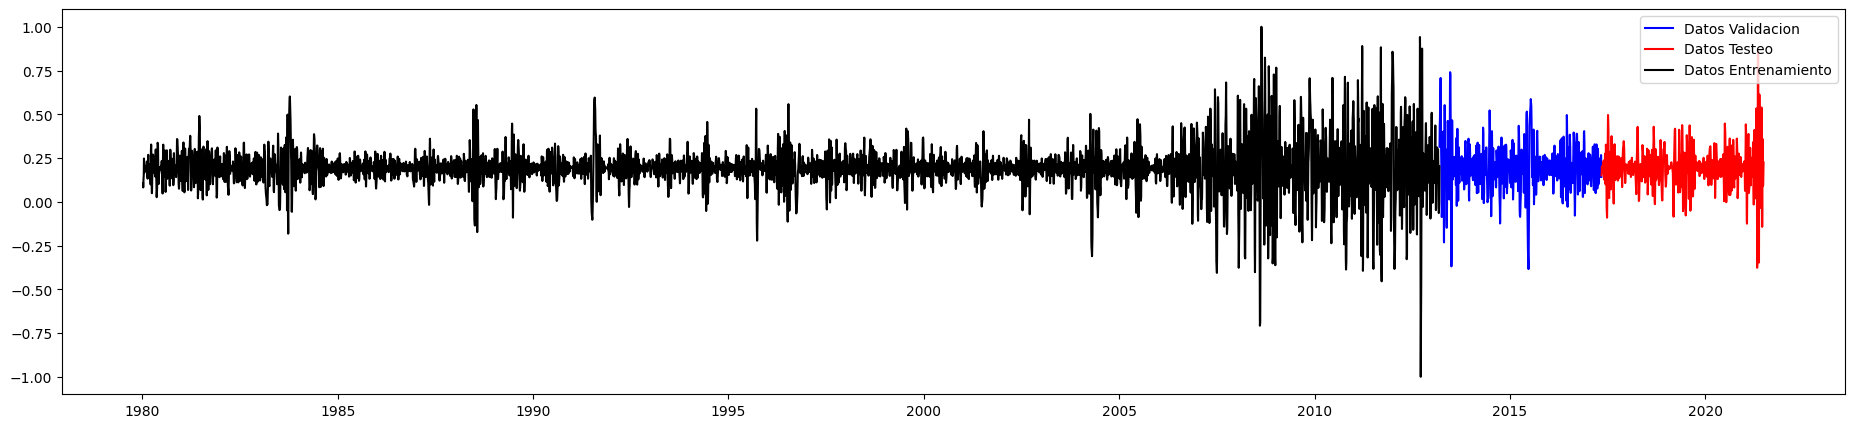

In [23]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_m2.index,datos_validacion_m2.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [24]:
learning_rate = [0.01, 0.1, 0.2]
max_depth = [2,3, 4, 5,6,7,8]
subsample = [0.8, 0.9, 1.0]
colsample_bytree = [0.7,0.8, 0.9, 1.0]

errores_learning_rate = []
errores_max_depth = {"i":{"j":[]}}
errores = []

X_train = datos_entrenamiento_m2[CARACTERISTICAS]
y_train =  datos_entrenamiento_m2.Precio_Cierre

X_test = datos_validacion_m2[CARACTERISTICAS]
y_test = datos_validacion_m2.Precio_Cierre

for i in learning_rate:
  for j in max_depth:
    for k in subsample:
      reg = xgb.XGBRegressor( base_score= None , booster= None ,
                            n_estimators= 1000 ,
                            early_stopping_rounds= 50 ,
                            subsample=k,
                            max_depth= j ,
                            learning_rate= i )


      reg.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=0)
      y_predict = reg.predict(datos_validacion_m2[CARACTERISTICAS])
      y_predict = pd.Series(y_predict)

      #score = mean_absolute_percentage_error(y_predict,datos_validacion_m2.Precio_Cierre)
      score = np.sqrt(mean_squared_error(y_predict,datos_validacion_m2.Precio_Cierre))

      errores.append((i,j,k,score))

In [25]:
indice, valor_minimo = min(enumerate(errores), key=lambda x: x[1][3])

print("El número más pequeño en la posición 3 de las tuplas es:", valor_minimo[3])
print("El índice de la tupla con el número más pequeño es:", indice)
print( f"el learning rate es {errores[indice][0]} el max_depth es {errores[indice][1]} y el subsample es {errores[indice][2]}")

El número más pequeño en la posición 3 de las tuplas es: 0.03291591
El índice de la tupla con el número más pequeño es: 18
el learning rate es 0.01 el max_depth es 8 y el subsample es 0.8


In [26]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
modo_2_sup = modo_2_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_2_sup[:division_validacion]) :
    train = modo_2_sup.iloc[train_idx]
    test = modo_2_sup.iloc[val_idx]

    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 6 ,
                           learning_rate= 0.01,
                            subsample= 1.0
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

    validacion_modo_2 = reg.predict(X_test)
    validacion_modo_2 = pd.Series(validacion_modo_2)
    preds.append(validacion_modo_2)
    score = np.sqrt(mean_squared_error(validacion_modo_2,y_test))
    mae = mean_absolute_error(validacion_modo_2,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_2,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_modo_2 = reg.predict(datos_validacion_m2[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

Puntuación entre pliegues 0.028063083067536354 
Puntuaciones plegar: [0.027699187, 0.03096654, 0.025523523] 
Error Absoluto medio entre pliegues 0.019880348816514015
porcentaje de error absoluto medio entre pliegues 0.2513338625431061


In [27]:
OBJETIVO = 'Precio_Cierre'

X_train=modo_2_sup[CARACTERISTICAS][:division_validacion]
y_train = modo_2_sup[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)


prediccion_modo_2 = reg.predict(datos_testeo_m2[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo_m2[OBJETIVO],prediccion_modo_2))

print(f"El error Cuadratico medio del modelo es {score}")

El error Cuadratico medio del modelo es 0.03256566449999809


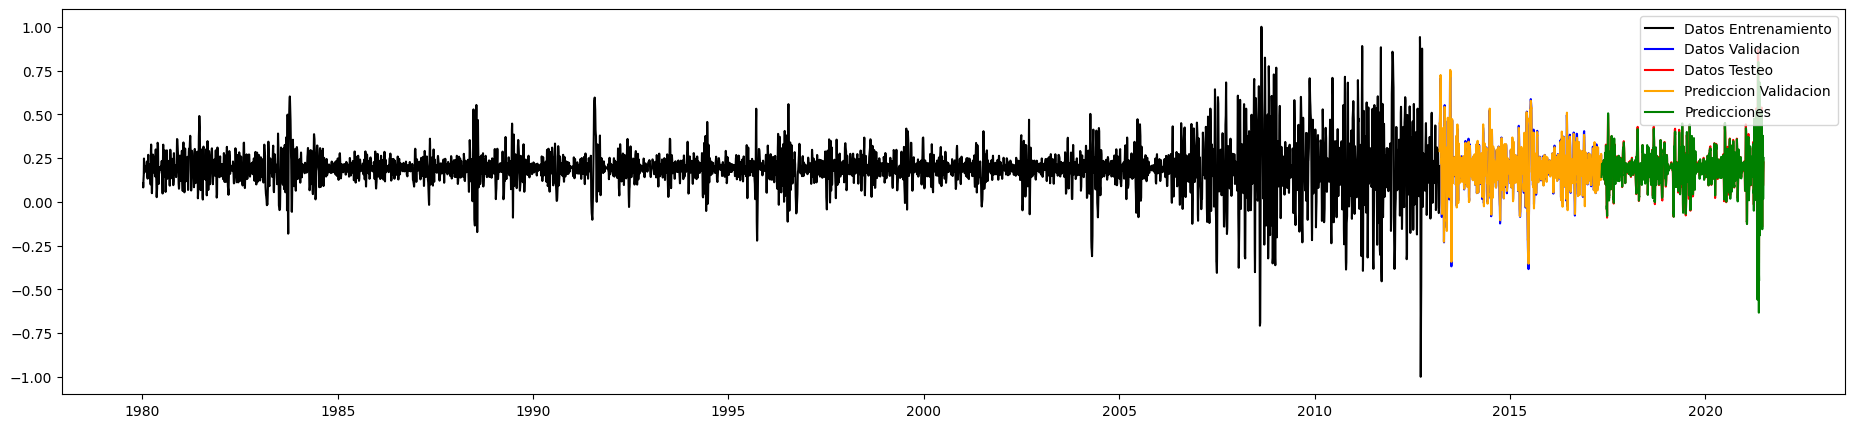

In [28]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m2.index,datos_validacion_m2.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_m2.index,validacion_modo_2,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_m2.index,prediccion_modo_2,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [29]:
validacion_modo_2 = modo_2_scaler.inverse_transform(validacion_modo_2.reshape(-1, 1))
prediccion_modo_2 = modo_2_scaler.inverse_transform(prediccion_modo_2.reshape(-1, 1))

# Modelaremos el 3 modo

In [30]:
modo_3 = modo_3.asfreq('D')
modo_3.interpolate(inplace=True)

In [31]:
modo_3_values = modo_3.values
modo_3_values = modo_3_values.astype('float32')
modo_3_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_3_values = modo_3_values.reshape(-1, 1)
modo_3_escalado =  pd.DataFrame(modo_3_scaler.fit_transform(modo_3_values), columns=modo_3.columns,index=modo_3.index)
modo_3_sup = add_lags(modo_3_escalado, PASOS)
modo_3_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,0.088243,0.091920,0.095597,0.099274,0.102951,0.106627,0.128091,0.151156
1980-01-10,0.074415,0.088243,0.091920,0.095597,0.099274,0.102951,0.106627,0.128091
1980-01-11,0.066249,0.074415,0.088243,0.091920,0.095597,0.099274,0.102951,0.106627
1980-01-12,0.065291,0.066249,0.074415,0.088243,0.091920,0.095597,0.099274,0.102951
1980-01-13,0.064333,0.065291,0.066249,0.074415,0.088243,0.091920,0.095597,0.099274


In [32]:
total_datos=len(modo_3_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m3 = modo_3_sup[:division_entrenamiento]
datos_validacion_m3 = modo_3_sup[division_entrenamiento:division_validacion]
datos_testeo_m3 = modo_3_sup[division_validacion:total_datos]

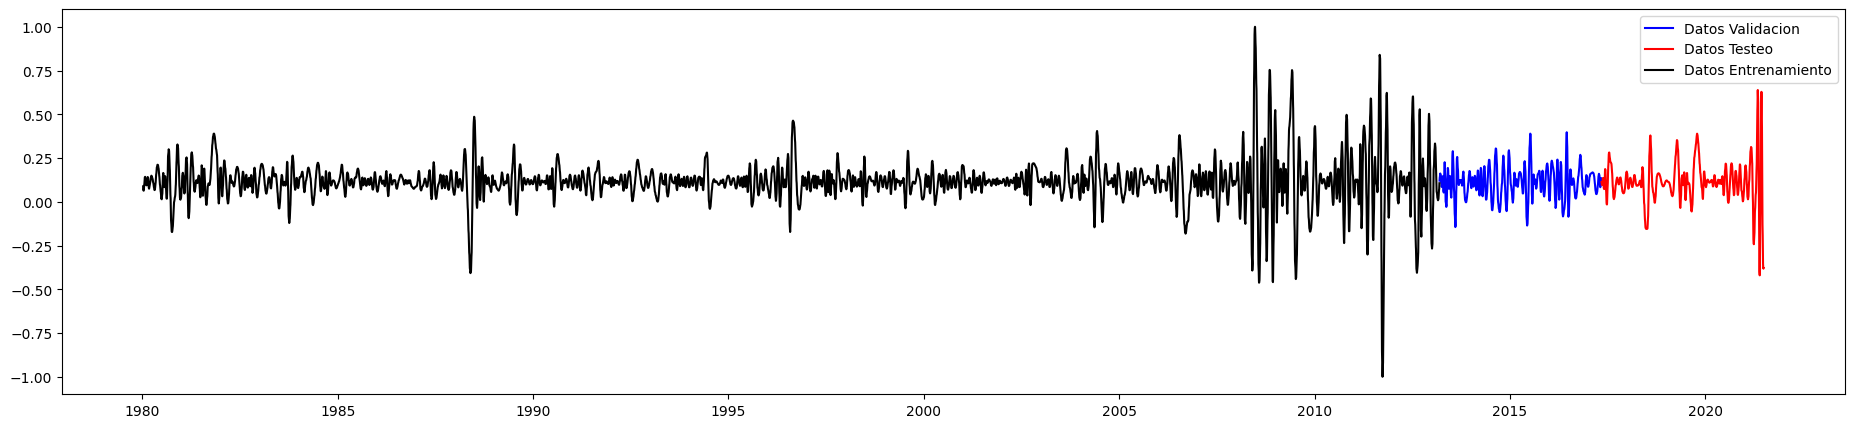

In [33]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_m3.index,datos_validacion_m3.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m3.index,datos_testeo_m3.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_m3.index,datos_entrenamiento_m3.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

Se hizo es una busque da hiperparametros y se encontro que los mejores hiperparametros son max depth 5 y learning rate 0.1

In [34]:
learning_rate = [0.01, 0.1, 0.2]
max_depth = [2,3, 4, 5,6,7,8]
subsample = [0.8, 0.9, 1.0]
colsample_bytree = [0.7,0.8, 0.9, 1.0]

errores_learning_rate = []
errores_max_depth = {"i":{"j":[]}}
errores = []

X_train = datos_entrenamiento_m3[CARACTERISTICAS]
y_train =  datos_entrenamiento_m3.Precio_Cierre

X_test = datos_validacion_m3[CARACTERISTICAS]
y_test = datos_validacion_m3.Precio_Cierre

for i in learning_rate:
  for j in max_depth:
    for k in subsample:
      reg = xgb.XGBRegressor( base_score= None , booster= None ,
                            n_estimators= 1000 ,
                            early_stopping_rounds= 50 ,
                            subsample=k,
                            max_depth= j ,
                            learning_rate= i )


      reg.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=0)
      y_predict = reg.predict(datos_validacion_m3[CARACTERISTICAS])
      y_predict = pd.Series(y_predict)

      score = mean_absolute_percentage_error(y_predict,datos_validacion_m3.Precio_Cierre)
      #score = np.sqrt(mean_squared_error(y_predict,datos_validacion.Precio_Cierre))

      errores.append((i,j,k,score))

In [35]:
indice, valor_minimo = min(enumerate(errores), key=lambda x: x[1][3])

print("El número más pequeño en la posición 3 de las tuplas es:", valor_minimo[3])
print("El índice de la tupla con el número más pequeño es:", indice)
print( f"el learning rate es {errores[indice][0]} el max_depth es {errores[indice][1]} y el subsample es {errores[indice][2]}")

El número más pequeño en la posición 3 de las tuplas es: 0.119906746
El índice de la tupla con el número más pequeño es: 57
el learning rate es 0.2 el max_depth es 7 y el subsample es 0.8


In [36]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
modo_3_sup = modo_3_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_3_sup[:division_validacion]) :
    train = modo_3_sup.iloc[train_idx]
    test = modo_3_sup.iloc[val_idx]


    CARACTERISTICAS = [ "retraso-1", "retraso-2",	"retraso-3",	"retraso-4",	"retraso-5",	"retraso-6",	"retraso-7"]
    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 6 ,
                           learning_rate= 0.01,
                            subsample= 1.0
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

    validacion_modo_3 = reg.predict(X_test)
    validacion_modo_3 = pd.Series(validacion_modo_3)
    preds.append(validacion_modo_3)
    score = np.sqrt(mean_squared_error(validacion_modo_3,y_test))
    mae = mean_absolute_error(validacion_modo_3,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_3,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_modo_3 = reg.predict(datos_validacion_m3[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

Puntuación entre pliegues 0.007279513869434595 
Puntuaciones plegar: [0.0064158607, 0.008723423, 0.006699259] 
Error Absoluto medio entre pliegues 0.0054383594542741776
porcentaje de error absoluto medio entre pliegues 0.11718913167715073


In [37]:
OBJETIVO = 'Precio_Cierre'

X_train=modo_3_sup[CARACTERISTICAS][:division_validacion]
y_train = modo_3_sup[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


prediccion_modo_3 = reg.predict(datos_testeo_m3[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo_m3[OBJETIVO],prediccion_modo_3))

print(f"El error Cuadratico medio del modelo es {score}")

[0]	validation_0-rmse:0.11841	validation_1-rmse:0.08595
[100]	validation_0-rmse:0.04735	validation_1-rmse:0.03259
[200]	validation_0-rmse:0.02341	validation_1-rmse:0.01371
[300]	validation_0-rmse:0.01679	validation_1-rmse:0.00771
[400]	validation_0-rmse:0.01524	validation_1-rmse:0.00621
[500]	validation_0-rmse:0.01482	validation_1-rmse:0.00579
[600]	validation_0-rmse:0.01465	validation_1-rmse:0.00557
[700]	validation_0-rmse:0.01454	validation_1-rmse:0.00537
[800]	validation_0-rmse:0.01446	validation_1-rmse:0.00524
[900]	validation_0-rmse:0.01438	validation_1-rmse:0.00515
[999]	validation_0-rmse:0.01432	validation_1-rmse:0.00507
El error Cuadratico medio del modelo es 0.019728191196918488


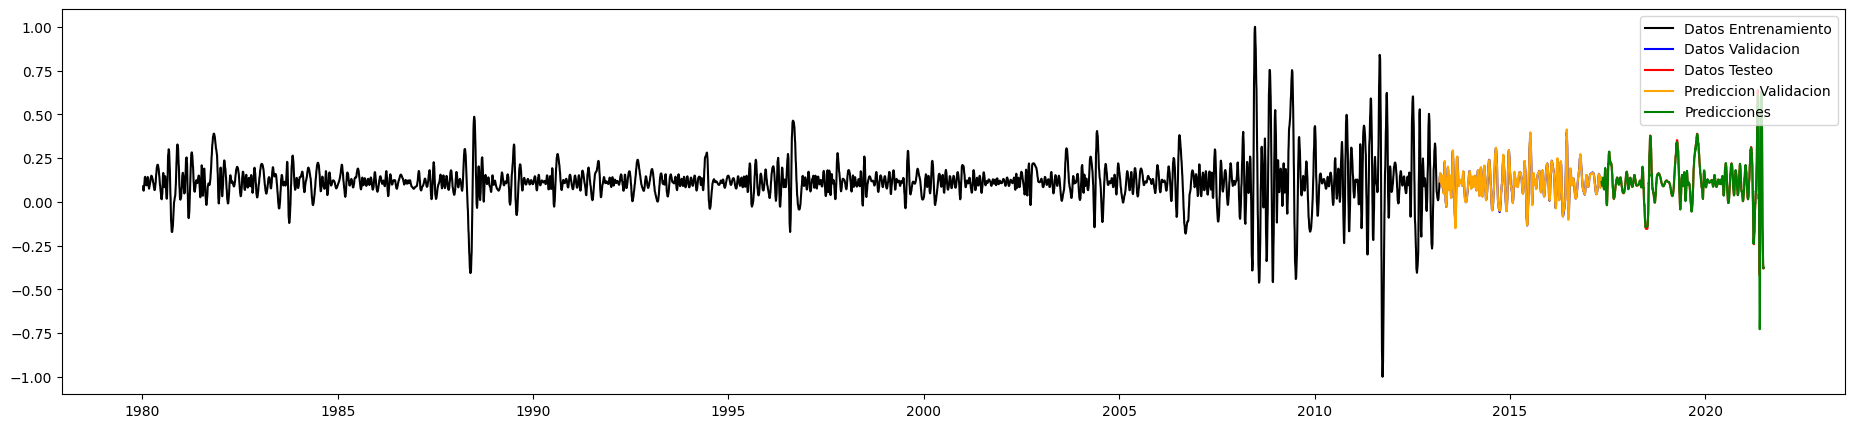

In [38]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m3.index,datos_entrenamiento_m3.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m3.index,datos_validacion_m3.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m3.index,datos_testeo_m3.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_m3.index,validacion_modo_3,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_m3.index,prediccion_modo_3,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [39]:
validacion_modo_3 = modo_3_scaler.inverse_transform(validacion_modo_3.reshape(-1, 1))
prediccion_modo_3 = modo_3_scaler.inverse_transform(prediccion_modo_3.reshape(-1, 1))

# modelaremos el modo 4

In [40]:
modo_4 = modo_4.asfreq('D')
modo_4.interpolate(inplace=True)

In [41]:
modo_4_values = modo_4.values
modo_4_values = modo_4_values.astype('float32')
modo_4_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_4_values = modo_4_values.reshape(-1, 1)
modo_4_escalado =  pd.DataFrame(modo_4_scaler.fit_transform(modo_4_values), columns=modo_4.columns,index=modo_4.index)
modo_4_sup = add_lags(modo_4_escalado, PASOS)
modo_4_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,-0.058778,-0.057618,-0.056459,-0.055300,-0.054141,-0.052982,-0.046625,-0.039828
1980-01-10,-0.063889,-0.058778,-0.057618,-0.056459,-0.055300,-0.054141,-0.052982,-0.046625
1980-01-11,-0.068195,-0.063889,-0.058778,-0.057618,-0.056459,-0.055300,-0.054141,-0.052982
1980-01-12,-0.069320,-0.068195,-0.063889,-0.058778,-0.057618,-0.056459,-0.055300,-0.054141
1980-01-13,-0.070446,-0.069320,-0.068195,-0.063889,-0.058778,-0.057618,-0.056459,-0.055300


In [42]:
total_datos=len(modo_4_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m4 = modo_4_sup[:division_entrenamiento]
datos_validacion_m4 = modo_4_sup[division_entrenamiento:division_validacion]
datos_testeo_m4 = modo_4_sup[division_validacion:total_datos]

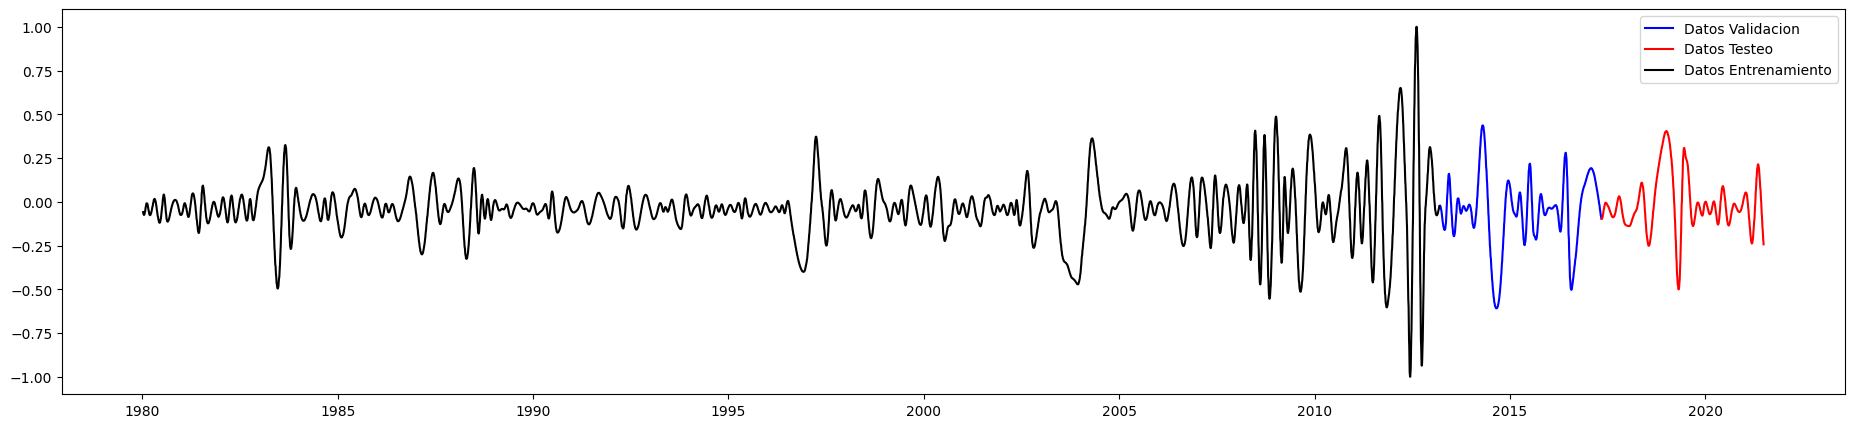

In [43]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_m4.index,datos_validacion_m4.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m4.index,datos_testeo_m4.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_m4.index,datos_entrenamiento_m4.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [44]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
modo_4_sup = modo_4_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_4_sup[:division_validacion]) :
    train = modo_4_sup.iloc[train_idx]
    test = modo_4_sup.iloc[val_idx]


    CARACTERISTICAS = [ "retraso-1", "retraso-2",	"retraso-3",	"retraso-4",	"retraso-5",	"retraso-6",	"retraso-7"]
    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 6 ,
                           learning_rate= 0.01,
                            subsample= 1.0
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    validacion_modo_4 = reg.predict(X_test)
    validacion_modo_4 = pd.Series(validacion_modo_4)
    preds.append(validacion_modo_4)
    score = np.sqrt(mean_squared_error(validacion_modo_4,y_test))
    mae = mean_absolute_error(validacion_modo_4,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_4,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_modo_4 = reg.predict(datos_validacion_m4[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

[0]	validation_0-rmse:0.16409	validation_1-rmse:0.28427
[100]	validation_0-rmse:0.06218	validation_1-rmse:0.10844
[200]	validation_0-rmse:0.02594	validation_1-rmse:0.04298
[300]	validation_0-rmse:0.01470	validation_1-rmse:0.02035
[400]	validation_0-rmse:0.01201	validation_1-rmse:0.01290
[500]	validation_0-rmse:0.01143	validation_1-rmse:0.01079
[600]	validation_0-rmse:0.01126	validation_1-rmse:0.01021
[700]	validation_0-rmse:0.01120	validation_1-rmse:0.01001
[800]	validation_0-rmse:0.01116	validation_1-rmse:0.00995
[900]	validation_0-rmse:0.01113	validation_1-rmse:0.00989
[999]	validation_0-rmse:0.01111	validation_1-rmse:0.00985
[0]	validation_0-rmse:0.16867	validation_1-rmse:0.10478
[100]	validation_0-rmse:0.06384	validation_1-rmse:0.03875
[200]	validation_0-rmse:0.02659	validation_1-rmse:0.01503
[300]	validation_0-rmse:0.01508	validation_1-rmse:0.00704
[400]	validation_0-rmse:0.01237	validation_1-rmse:0.00468
[500]	validation_0-rmse:0.01180	validation_1-rmse:0.00416
[600]	validation_0

In [45]:
OBJETIVO = 'Precio_Cierre'

X_train=modo_4_sup[CARACTERISTICAS][:division_validacion]
y_train = modo_4_sup[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


prediccion_modo_4 = reg.predict(datos_testeo_m4[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo_m4[OBJETIVO],prediccion_modo_4))

print(f"El error Cuadratico medio del modelo es {score}")

[0]	validation_0-rmse:0.16890	validation_1-rmse:0.22079
[100]	validation_0-rmse:0.06396	validation_1-rmse:0.08106
[200]	validation_0-rmse:0.02672	validation_1-rmse:0.03018
[300]	validation_0-rmse:0.01527	validation_1-rmse:0.01221
[400]	validation_0-rmse:0.01259	validation_1-rmse:0.00658
[500]	validation_0-rmse:0.01203	validation_1-rmse:0.00518
[600]	validation_0-rmse:0.01187	validation_1-rmse:0.00486
[700]	validation_0-rmse:0.01181	validation_1-rmse:0.00469
[800]	validation_0-rmse:0.01178	validation_1-rmse:0.00457
[900]	validation_0-rmse:0.01175	validation_1-rmse:0.00449
[999]	validation_0-rmse:0.01172	validation_1-rmse:0.00442
El error Cuadratico medio del modelo es 0.005023985635489225


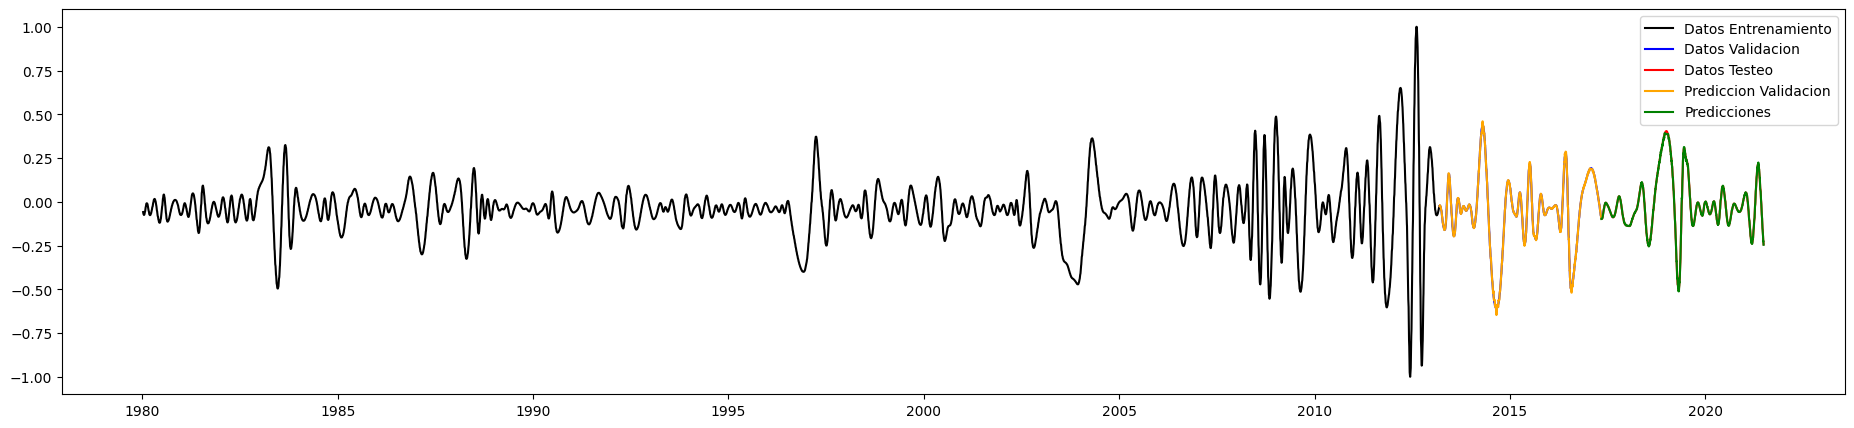

In [46]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m4.index,datos_entrenamiento_m4.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m4.index,datos_validacion_m4.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m4.index,datos_testeo_m4.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_m4.index,validacion_modo_4,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_m4.index,prediccion_modo_4,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [47]:
validacion_modo_4 = modo_4_scaler.inverse_transform(validacion_modo_4.reshape(-1, 1))
prediccion_modo_4 = modo_4_scaler.inverse_transform(prediccion_modo_4.reshape(-1, 1))

# modelaremos el modo 5

In [48]:
modo_5 = modo_5.asfreq('D')
modo_5.interpolate(inplace=True)

In [49]:
modo_5_values = modo_5.values
modo_5_values = modo_5_values.astype('float32')
modo_5_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_5_values = modo_5_values.reshape(-1, 1)
modo_5_escalado =  pd.DataFrame(modo_5_scaler.fit_transform(modo_5_values), columns=modo_5.columns,index=modo_5.index)
modo_5_sup = add_lags(modo_5_escalado, PASOS)
modo_5_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,0.101723,0.102050,0.102378,0.102705,0.103032,0.103360,0.104982,0.106591
1980-01-10,0.100071,0.101723,0.102050,0.102378,0.102705,0.103032,0.103360,0.104982
1980-01-11,0.098404,0.100071,0.101723,0.102050,0.102378,0.102705,0.103032,0.103360
1980-01-12,0.097843,0.098404,0.100071,0.101723,0.102050,0.102378,0.102705,0.103032
1980-01-13,0.097282,0.097843,0.098404,0.100071,0.101723,0.102050,0.102378,0.102705


In [50]:
total_datos=len(modo_5_sup)
#modo_4_sup = modo_4_sup.values
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m5 = modo_5_sup[:division_entrenamiento]
datos_validacion_m5 = modo_5_sup[division_entrenamiento:division_validacion]
datos_testeo_m5 = modo_5_sup[division_validacion:total_datos]

datos_entrenamiento_m5_values= datos_entrenamiento_m5.values
datos_validacion_m5_values = datos_validacion_m5.values
datos_testeo_m5_values = datos_testeo_m5.values

In [51]:
total_datos=len(modo_5.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = modo_5[:division_entrenamiento]
datos_validacion = modo_5[division_entrenamiento:division_validacion]
datos_testeo = modo_5[division_validacion:total_datos]

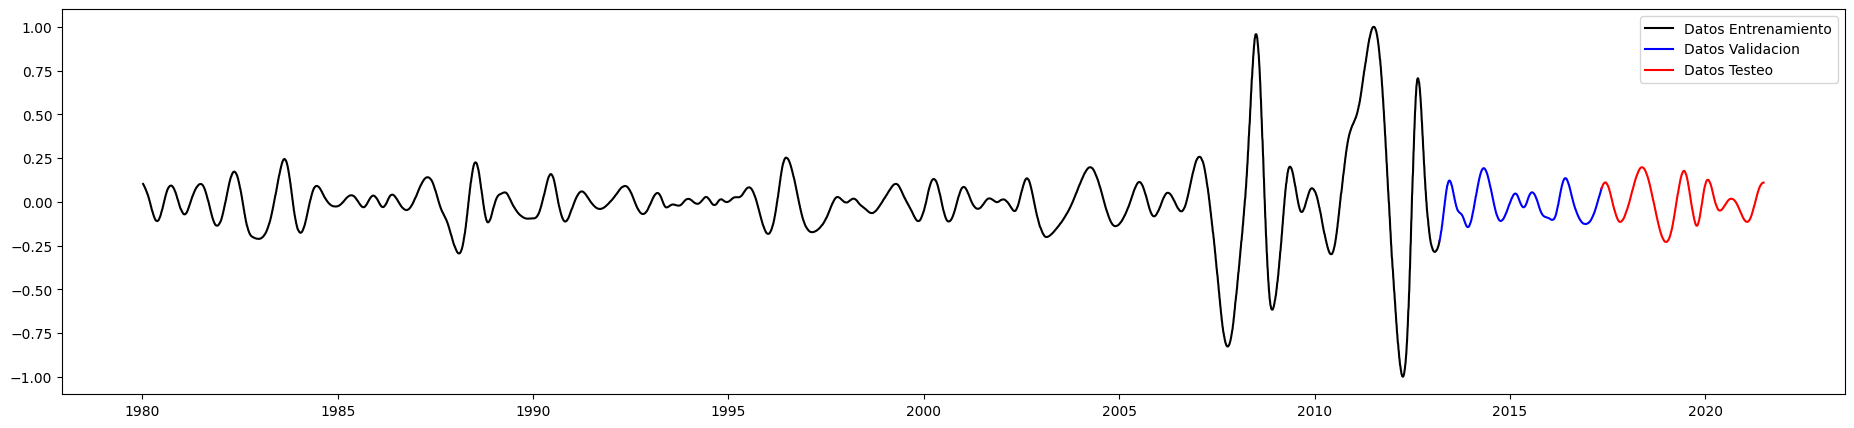

In [52]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m5.index,datos_entrenamiento_m5.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m5.index,datos_validacion_m5.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m5.index,datos_testeo_m5.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [53]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
modo_5_sup = modo_5_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_5_sup[:division_validacion]) :
    train = modo_5_sup.iloc[train_idx]
    test = modo_5_sup.iloc[val_idx]

    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 6 ,
                           learning_rate= 0.2,
                            subsample=0.8
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    validacion_modo_5 = reg.predict(X_test)
    validacion_modo_5 = pd.Series(validacion_modo_5)
    preds.append( validacion_modo_5)
    score = np.sqrt(mean_squared_error( validacion_modo_5,y_test))
    mae = mean_absolute_error( validacion_modo_5,y_test)
    mape = mean_absolute_percentage_error( validacion_modo_5,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_modo_5 = reg.predict(datos_validacion_m5[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

[0]	validation_0-rmse:0.18303	validation_1-rmse:0.06169
[100]	validation_0-rmse:0.00545	validation_1-rmse:0.00167
[200]	validation_0-rmse:0.00537	validation_1-rmse:0.00159
[300]	validation_0-rmse:0.00534	validation_1-rmse:0.00154
[400]	validation_0-rmse:0.00533	validation_1-rmse:0.00152
[500]	validation_0-rmse:0.00532	validation_1-rmse:0.00150
[600]	validation_0-rmse:0.00531	validation_1-rmse:0.00149
[640]	validation_0-rmse:0.00531	validation_1-rmse:0.00149
[0]	validation_0-rmse:0.18076	validation_1-rmse:0.05220
[100]	validation_0-rmse:0.00538	validation_1-rmse:0.00160
[200]	validation_0-rmse:0.00527	validation_1-rmse:0.00151
[300]	validation_0-rmse:0.00525	validation_1-rmse:0.00148
[400]	validation_0-rmse:0.00524	validation_1-rmse:0.00146
[500]	validation_0-rmse:0.00523	validation_1-rmse:0.00145
[600]	validation_0-rmse:0.00522	validation_1-rmse:0.00143
[697]	validation_0-rmse:0.00522	validation_1-rmse:0.00142
[0]	validation_0-rmse:0.17851	validation_1-rmse:0.07417
[100]	validation_0-r

In [54]:
errores

[(0.01, 2, 0.8, 0.25709873),
 (0.01, 2, 0.9, 0.24056837),
 (0.01, 2, 1.0, 0.23514855),
 (0.01, 3, 0.8, 0.19410613),
 (0.01, 3, 0.9, 0.17191963),
 (0.01, 3, 1.0, 0.1553034),
 (0.01, 4, 0.8, 0.14394017),
 (0.01, 4, 0.9, 0.14606602),
 (0.01, 4, 1.0, 0.28119516),
 (0.01, 5, 0.8, 0.1707729),
 (0.01, 5, 0.9, 0.19713254),
 (0.01, 5, 1.0, 0.13943554),
 (0.01, 6, 0.8, 0.16665961),
 (0.01, 6, 0.9, 0.2553742),
 (0.01, 6, 1.0, 0.15456307),
 (0.01, 7, 0.8, 0.14700176),
 (0.01, 7, 0.9, 0.15093426),
 (0.01, 7, 1.0, 0.31818792),
 (0.01, 8, 0.8, 0.13593204),
 (0.01, 8, 0.9, 0.13021526),
 (0.01, 8, 1.0, 0.19517572),
 (0.1, 2, 0.8, 0.16312447),
 (0.1, 2, 0.9, 0.2376504),
 (0.1, 2, 1.0, 0.14889082),
 (0.1, 3, 0.8, 0.1696685),
 (0.1, 3, 0.9, 0.15583989),
 (0.1, 3, 1.0, 0.29947722),
 (0.1, 4, 0.8, 0.14684351),
 (0.1, 4, 0.9, 0.15563832),
 (0.1, 4, 1.0, 0.13736843),
 (0.1, 5, 0.8, 0.18840563),
 (0.1, 5, 0.9, 0.1939169),
 (0.1, 5, 1.0, 0.15766603),
 (0.1, 6, 0.8, 0.2501896),
 (0.1, 6, 0.9, 0.283708),
 (0.1, 6

In [55]:
OBJETIVO = 'Precio_Cierre'

X_train=modo_5_sup[CARACTERISTICAS][:division_validacion]
y_train = modo_5_sup[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


prediccion_modo_5 = reg.predict(datos_testeo_m5[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo_m5[OBJETIVO],prediccion_modo_5))

print(f"El error Cuadratico medio del modelo es {score}")

[0]	validation_0-rmse:0.17645	validation_1-rmse:0.07290
[100]	validation_0-rmse:0.00568	validation_1-rmse:0.00169
[200]	validation_0-rmse:0.00562	validation_1-rmse:0.00161
[300]	validation_0-rmse:0.00559	validation_1-rmse:0.00151
[400]	validation_0-rmse:0.00557	validation_1-rmse:0.00150
[438]	validation_0-rmse:0.00557	validation_1-rmse:0.00150
El error Cuadratico medio del modelo es 0.0022757963743060827


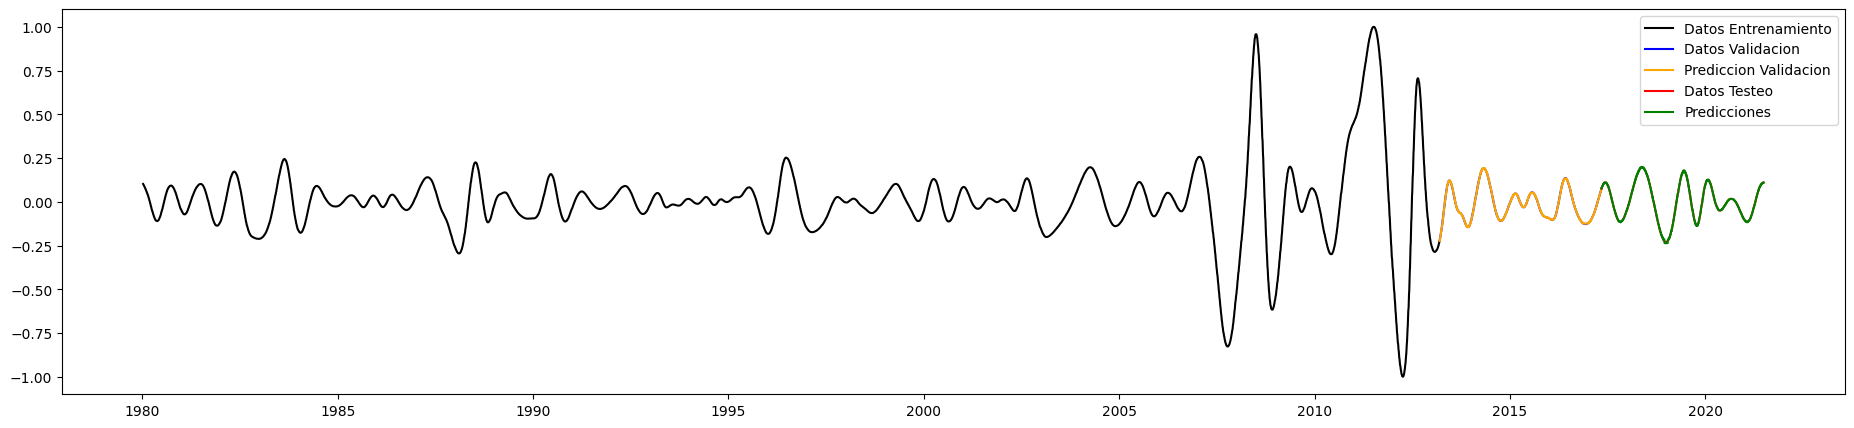

In [56]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m5.index,datos_entrenamiento_m5.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m5.index,datos_validacion_m5.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m5.index,validacion_modo_5,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_m5.index,datos_testeo_m5.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m5.index,prediccion_modo_5,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [57]:
validacion_modo_5 = modo_5_scaler.inverse_transform(validacion_modo_5.reshape(-1, 1))
prediccion_modo_5 = modo_5_scaler.inverse_transform(prediccion_modo_5.reshape(-1, 1))

# Modelaremos el residuo

In [58]:
residuo = residuo.asfreq('D')
residuo.interpolate(inplace=True)

In [59]:
residuo_values = residuo.values
residuo_values = residuo_values.astype('float32')
residuo_scaler = MinMaxScaler(feature_range=(-1, 1))
residuo_values = residuo_values.reshape(-1, 1)
residuo_escalado =  pd.DataFrame(residuo_scaler.fit_transform(residuo_values), columns=residuo.columns,index=residuo.index)
residuo_sup = add_lags(residuo_escalado, PASOS)
residuo_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,-0.498063,-0.498229,-0.498394,-0.498560,-0.498725,-0.498891,-0.499712,-0.500525
1980-01-10,-0.497228,-0.498063,-0.498229,-0.498394,-0.498560,-0.498725,-0.498891,-0.499712
1980-01-11,-0.496386,-0.497228,-0.498063,-0.498229,-0.498394,-0.498560,-0.498725,-0.498891
1980-01-12,-0.496103,-0.496386,-0.497228,-0.498063,-0.498229,-0.498394,-0.498560,-0.498725
1980-01-13,-0.495820,-0.496103,-0.496386,-0.497228,-0.498063,-0.498229,-0.498394,-0.498560


In [60]:
total_datos=len(residuo_sup)

porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_residuo = residuo_sup[:division_entrenamiento]
datos_validacion_residuo = residuo_sup[division_entrenamiento:division_validacion]
datos_testeo_residuo= residuo_sup[division_validacion:total_datos]

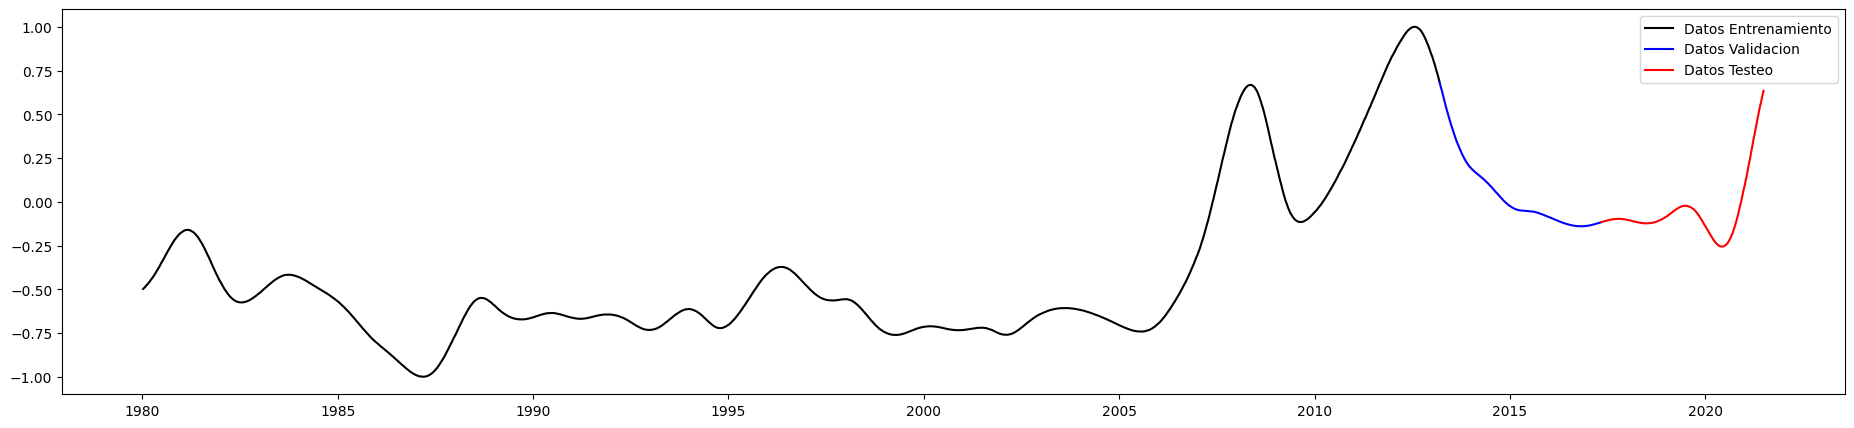

In [61]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [62]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
residuo = residuo_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(residuo_sup[:division_validacion]) :
    train = residuo_sup.iloc[train_idx]
    test = residuo_sup.iloc[val_idx]



    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 4 ,
                           learning_rate= 0.1,
                            subsample=0.8)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    validacion_residuo = reg.predict(X_test)
    validacion_residuo = pd.Series(validacion_residuo)
    preds.append(validacion_residuo)
    score = np.sqrt(mean_squared_error(validacion_residuo,y_test))
    mae = mean_absolute_error(validacion_residuo,y_test)
    mape = mean_absolute_percentage_error(validacion_residuo,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_residuo = reg.predict(datos_validacion_residuo[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

[0]	validation_0-rmse:0.41624	validation_1-rmse:0.38529
[100]	validation_0-rmse:0.00334	validation_1-rmse:0.00648
[101]	validation_0-rmse:0.00334	validation_1-rmse:0.00648
[0]	validation_0-rmse:0.41524	validation_1-rmse:0.28678
[100]	validation_0-rmse:0.00330	validation_1-rmse:0.00471
[200]	validation_0-rmse:0.00325	validation_1-rmse:0.00468
[226]	validation_0-rmse:0.00324	validation_1-rmse:0.00468
[0]	validation_0-rmse:0.41216	validation_1-rmse:0.22491
[100]	validation_0-rmse:0.00330	validation_1-rmse:0.01915
[106]	validation_0-rmse:0.00330	validation_1-rmse:0.01915
Puntuación entre pliegues 0.009831971488893032 
Puntuaciones plegar: [0.006182804, 0.004672411, 0.0186407] 
Error Absoluto medio entre pliegues 0.008815176784992218
porcentaje de error absoluto medio entre pliegues 0.12896806001663208


In [63]:
OBJETIVO = 'Precio_Cierre'

X_train=residuo_sup[CARACTERISTICAS][:division_validacion]
y_train = residuo_sup[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
prediccion_residuo = reg.predict(datos_testeo_residuo[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo_residuo[OBJETIVO],prediccion_residuo))

print(f"El error Cuadratico medio del modelo es {score}")

[0]	validation_0-rmse:0.40829	validation_1-rmse:0.22348
[100]	validation_0-rmse:0.00331	validation_1-rmse:0.00236
[200]	validation_0-rmse:0.00326	validation_1-rmse:0.00236
[238]	validation_0-rmse:0.00325	validation_1-rmse:0.00238
El error Cuadratico medio del modelo es 0.004126058891415596


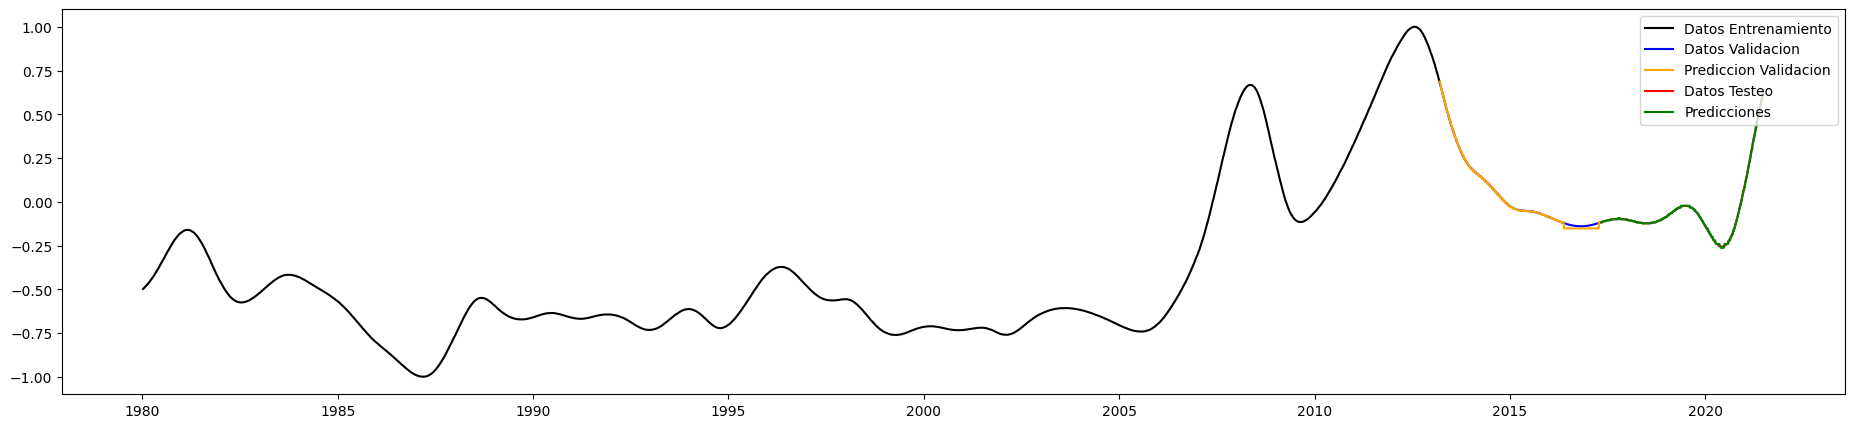

In [64]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_residuo.index,validacion_residuo,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_residuo.index,prediccion_residuo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [65]:
validacion_residuo = residuo_scaler.inverse_transform(validacion_residuo.reshape(-1, 1))
prediccion_residuo = residuo_scaler.inverse_transform(prediccion_residuo.reshape(-1, 1))

# Ensemble
vamos a hacer el ensemble de todos los modelos para obtener el modelo final

In [66]:
predicciones_emd = prediccion_modo_1 + prediccion_modo_2 + prediccion_modo_3 + prediccion_modo_4 + prediccion_modo_5 + prediccion_residuo

In [67]:
total_datos=len(datos_emd.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)

datos_entrenamiento = datos_emd[:division_entrenamiento]
datos_validacion = datos_emd[division_entrenamiento:division_validacion]
datos_testeo = datos_emd[division_validacion:total_datos]

Metricas validacion

In [68]:
validacion = validacion_modo_1 + validacion_modo_2 + validacion_modo_3 + validacion_modo_4 + validacion_modo_5 + validacion_residuo
recm_validacion = np.sqrt(mean_squared_error(validacion,datos_validacion.Precio_Cierre[:-1]))
eam_validacion = mean_absolute_error( validacion,datos_validacion.Precio_Cierre[:-1])
EPAM_validacion = mean_absolute_percentage_error( validacion,datos_validacion.Precio_Cierre[:-1])


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm_validacion} ' )
print ( f'el error absoluto medio del modelo es: {eam_validacion} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM_validacion}")

La raiz del error cuadratico medio del modelo es: 4.021226426127364 
el error absoluto medio del modelo es: 3.006808025539843 
Error porcentual absoluto medio del modelo es: 0.007121398309334192


Metricas de testeo del modelo

In [69]:
recm = np.sqrt(mean_squared_error( predicciones_emd,datos_testeo.Precio_Cierre))
eam = mean_absolute_error( predicciones_emd,datos_testeo.Precio_Cierre)
EPAM = mean_absolute_percentage_error(predicciones_emd,datos_testeo.Precio_Cierre)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm} ' )
print ( f'el error absoluto medio del modelo es: {eam} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM}")

La raiz del error cuadratico medio del modelo es: 3.1789839313541797 
el error absoluto medio del modelo es: 2.0096659060623403 
Error porcentual absoluto medio del modelo es: 0.004774853342834488


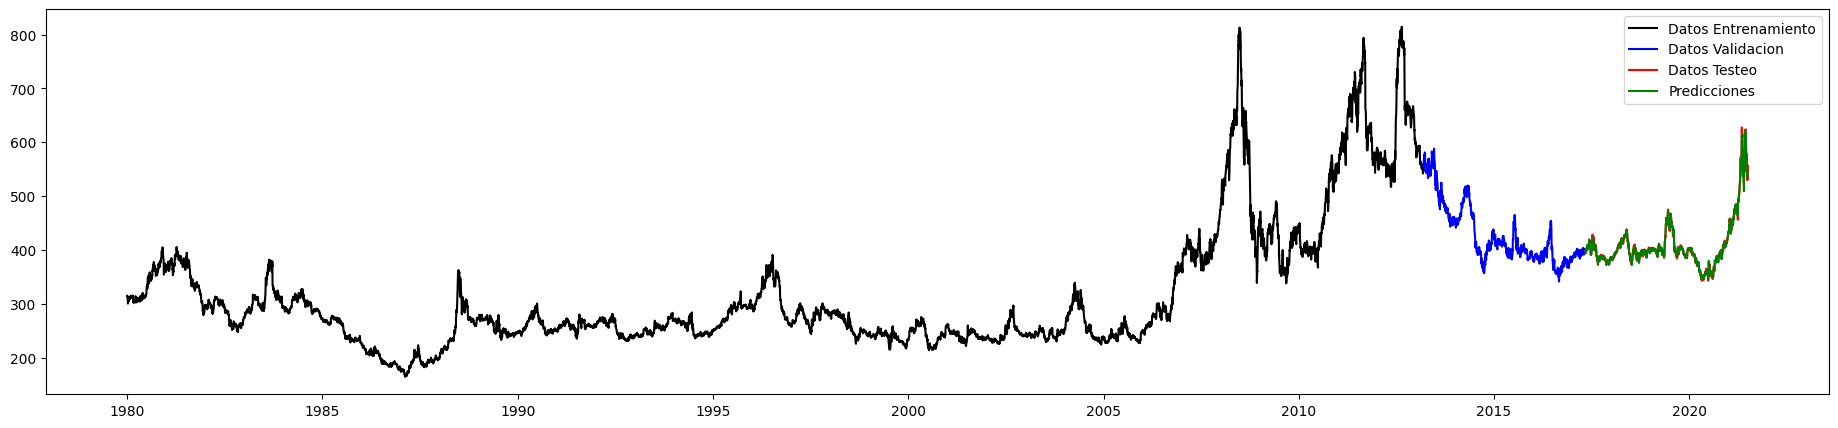

In [70]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
#ax.plot(datos_validacion.index,validacion,color='orange',label = 'Datos Testeo')
ax.plot(datos_testeo.index,predicciones_emd,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

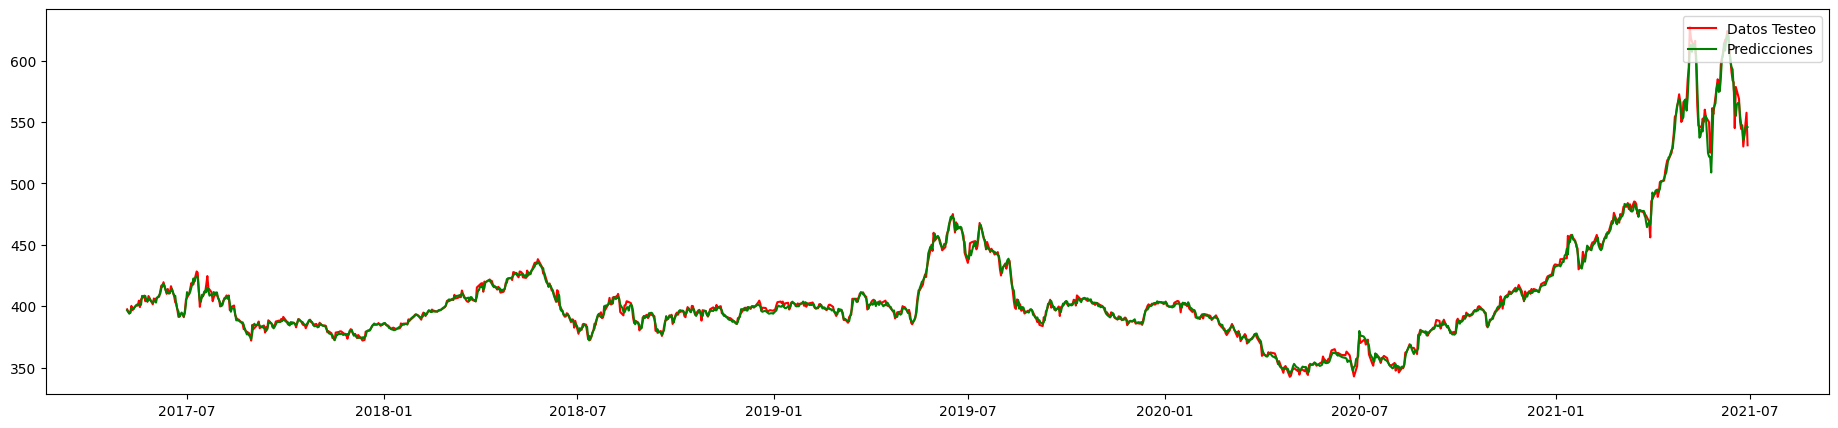

In [71]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,predicciones_emd,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [72]:
validacion =pd.DataFrame(validacion,index=datos_validacion.index[1:],columns=['Precio_Cierre'])
testeo = pd.DataFrame(predicciones_emd,index=datos_testeo.index,columns=['Precio_Cierre'])

In [73]:
validacion.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Predicciones/validacion_red_densa.csv",index=True)
testeo.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Predicciones/testeo_red_densa.csv",index=True)